In [1]:
!pip install -q torch torchvision transformers datasets timm

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SwinForImageClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import os


In [3]:
# Path to dataset directory
data_dir = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/'


In [4]:
# Define the 8 classes
classes = [
    'Actinic keratosis', 
    'Basal cell carcinoma', 
    'Benign keratosis', 
    'Dermatofibroma', 
    'Melanocytic nevus', 
    'Melanoma', 
    'Squamous cell carcinoma', 
    'Vascular lesion'
]

# Map class names to indices
label_mapping = {label: idx for idx, label in enumerate(classes)}


In [5]:
class ISICDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Loop through each class folder
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label_mapping[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
# Create the dataset
full_dataset = ISICDataset(data_dir, transform=transform)

# Split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-base-patch4-window7-224',
    num_labels=len(classes),
    ignore_mismatched_sizes=True
)

model.to(device)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([8, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")  # Added this
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Debug: Check if images and labels are loading correctly
        if batch_idx == 0:
            print(f"Loaded first batch - Images Shape: {images.shape}, Labels: {labels[:5]}")
        
        optimizer.zero_grad()
        outputs = model(images).logits
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Debug: Show progress for every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
    train_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%')



Starting Epoch 1/5...
Loaded first batch - Images Shape: torch.Size([32, 3, 224, 224]), Labels: tensor([4, 4, 1, 4, 2], device='cuda:0')
Batch [10/634], Loss: 1.3495
Batch [20/634], Loss: 0.8931
Batch [30/634], Loss: 0.6982
Batch [40/634], Loss: 1.0963
Batch [50/634], Loss: 1.1687
Batch [60/634], Loss: 1.3450
Batch [70/634], Loss: 0.5723
Batch [80/634], Loss: 1.0330
Batch [90/634], Loss: 1.0550
Batch [100/634], Loss: 0.9830
Batch [110/634], Loss: 0.5564
Batch [120/634], Loss: 1.0180
Batch [130/634], Loss: 0.6575
Batch [140/634], Loss: 0.8053
Batch [150/634], Loss: 1.1609
Batch [160/634], Loss: 0.6542
Batch [170/634], Loss: 0.9231
Batch [180/634], Loss: 0.6000
Batch [190/634], Loss: 1.2628
Batch [200/634], Loss: 1.0308
Batch [210/634], Loss: 0.9271
Batch [220/634], Loss: 0.6468
Batch [230/634], Loss: 0.5742
Batch [240/634], Loss: 0.6547
Batch [250/634], Loss: 0.7737
Batch [260/634], Loss: 0.7525
Batch [270/634], Loss: 1.0355
Batch [280/634], Loss: 0.7683
Batch [290/634], Loss: 0.7143
B

In [11]:
model.eval()


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Same transformations as during training
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled', 
    transform=test_transforms
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test Accuracy: 93.49%

Classification Report:
                          precision    recall  f1-score   support

      Actinic keratosis       0.86      0.85      0.86       867
   Basal cell carcinoma       0.82      0.99      0.90      3323
       Benign keratosis       0.93      0.92      0.92      2624
         Dermatofibroma       0.99      0.89      0.94       239
      Melanocytic nevus       0.98      0.95      0.97     12875
               Melanoma       0.93      0.90      0.91      4522
Squamous cell carcinoma       0.89      0.72      0.80       628
        Vascular lesion       0.99      0.92      0.96       253

               accuracy                           0.93     25331
              macro avg       0.92      0.89      0.91     25331
           weighted avg       0.94      0.93      0.94     25331



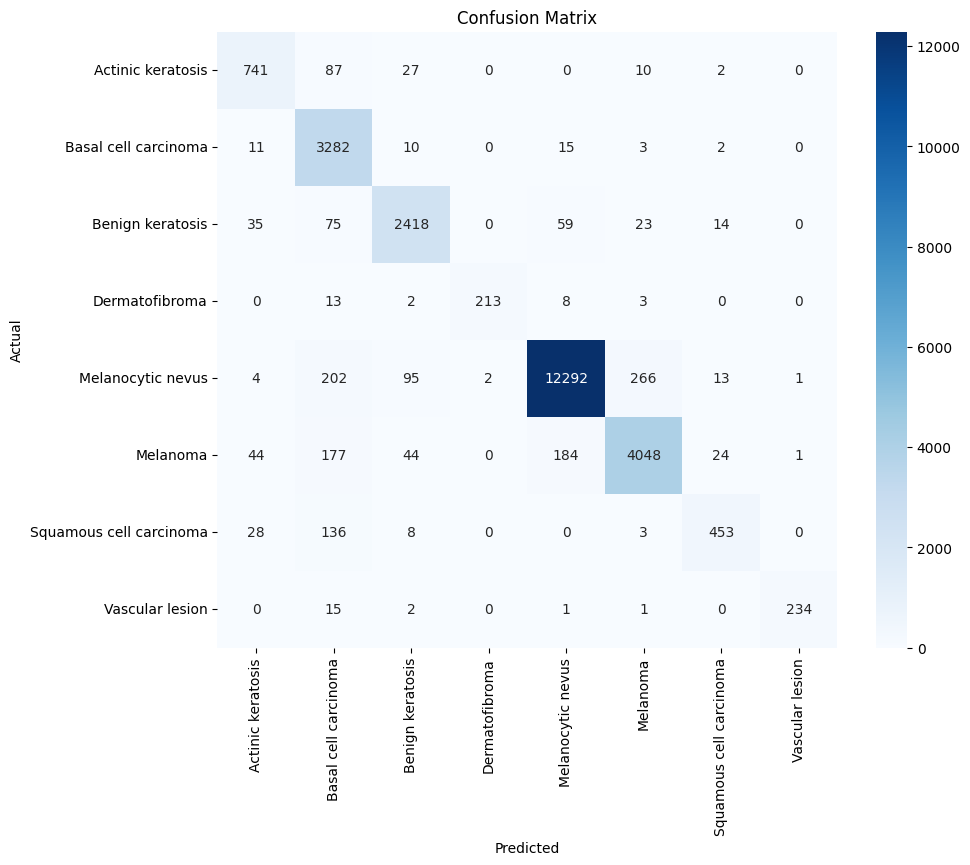

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

all_preds = []
all_labels = []

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
class_names = test_dataset.classes
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
torch.save(model.state_dict(), 'onculus.pth')


In [15]:
from PIL import Image
from torchvision import transforms

# Image transformations (same as training)
input_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0000002.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
input_tensor = input_transforms(image).unsqueeze(0).to(device)  # Add batch dimension


In [16]:
with torch.no_grad():
    outputs = model(input_tensor).logits
    _, predicted_class = torch.max(outputs, 1)

# Get class names from the dataset
class_names = test_dataset.classes
predicted_label = class_names[predicted_class.item()]

print(f'Predicted Class: {predicted_label}')


Predicted Class: Melanoma


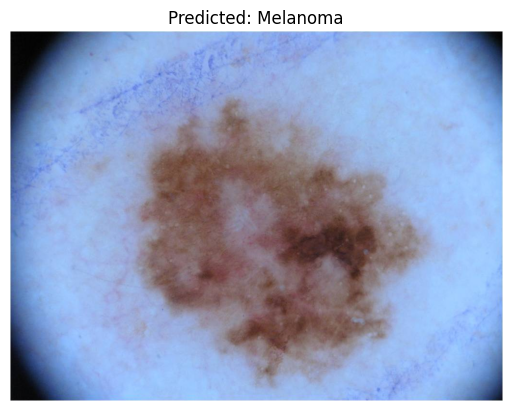

In [17]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import SwinForImageClassification
from PIL import Image
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class names
class_names = [
    'Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 
    'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 
    'Squamous cell carcinoma', 'Vascular lesion'
]

# Image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
# Dataset and DataLoader
root_dir = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'
dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [20]:
# Model Definition: Swin Transformer + CNN
class SwinCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SwinCNN, self).__init__()
        self.swin = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224', num_labels=num_classes, ignore_mismatched_sizes=True)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        swin_output = self.swin(pixel_values=x).logits
        return swin_output


In [21]:
# Initialize model, loss, and optimizer
model = SwinCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([8, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Display training progress
        print(f'Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}', end='')

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Save model

Batch 1/634, Loss: 2.2476Batch 2/634, Loss: 1.5228Batch 3/634, Loss: 1.8317Batch 4/634, Loss: 1.0910Batch 5/634, Loss: 1.3163Batch 6/634, Loss: 1.2516Batch 7/634, Loss: 1.4249Batch 8/634, Loss: 1.1477Batch 9/634, Loss: 1.1172Batch 10/634, Loss: 1.3236Batch 11/634, Loss: 0.9028Batch 12/634, Loss: 1.1816Batch 13/634, Loss: 1.3127Batch 14/634, Loss: 0.9594Batch 15/634, Loss: 1.7878Batch 16/634, Loss: 0.9195Batch 17/634, Loss: 1.1498Batch 18/634, Loss: 1.0291Batch 19/634, Loss: 1.0538Batch 20/634, Loss: 0.7720Batch 21/634, Loss: 1.1003Batch 22/634, Loss: 1.2026Batch 23/634, Loss: 1.3206Batch 24/634, Loss: 1.5584Batch 25/634, Loss: 1.0922Batch 26/634, Loss: 0.8633Batch 27/634, Loss: 1.3366Batch 28/634, Loss: 1.3650Batch 29/634, Loss: 0.9682Batch 30/634, Loss: 1.2287Batch 31/634, Loss: 1.0562Batch 32/634, Loss: 0.9247Batch 33/634, Loss: 0.8652Batch 34/634, Loss: 1.0910Batch 35/634, Loss: 0.9961Batch 36/634, Loss: 0.7774Batch 37/634, Loss: 0.8575Batch 38/634, Loss: 1.3806Batch 39/634, Loss: 0

In [23]:
torch.save(model.state_dict(), 'swin_cnn_onculus.pth')


Classification Report:                          precision    recall  f1-score   support

      Actinic keratosis       0.62      0.48      0.54       170
   Basal cell carcinoma       0.75      0.89      0.81       606
       Benign keratosis       0.73      0.57      0.64       543
         Dermatofibroma       0.90      0.42      0.57        43
      Melanocytic nevus       0.88      0.91      0.89      2603
               Melanoma       0.68      0.73      0.71       914
Squamous cell carcinoma       0.83      0.18      0.29       137
        Vascular lesion       0.87      0.76      0.81        51

               accuracy                           0.80      5067
              macro avg       0.78      0.62      0.66      5067
           weighted avg       0.80      0.80      0.79      5067



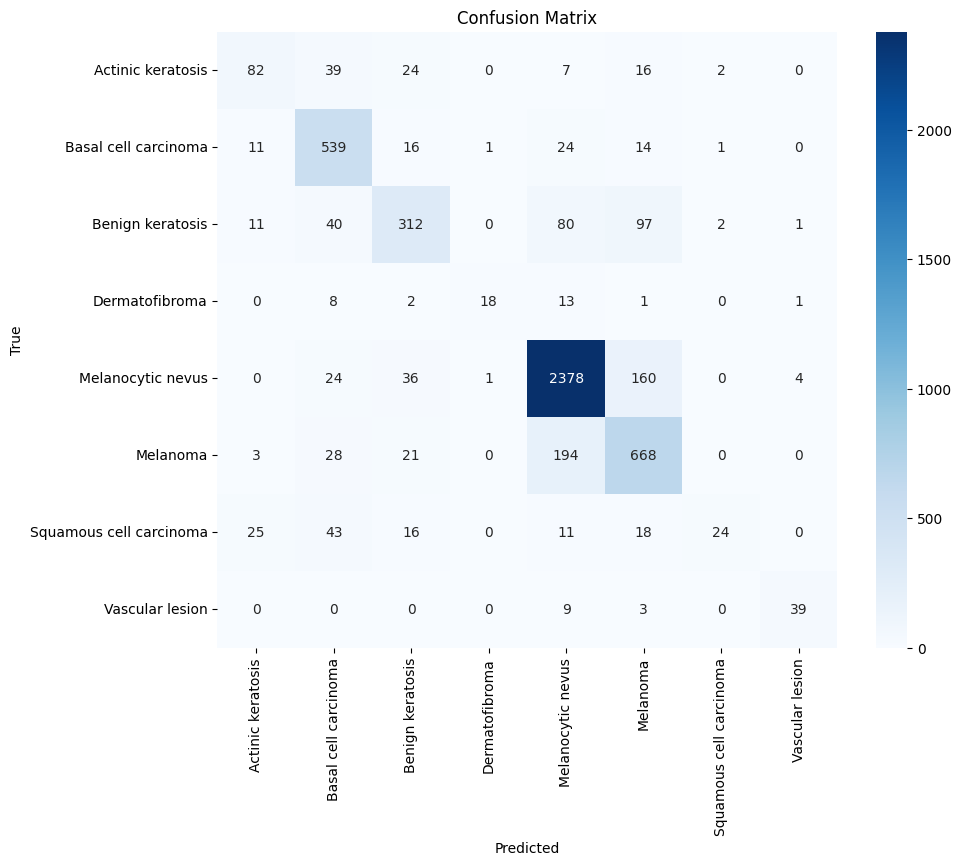

In [24]:
# Validation Loop
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy and Classification Report
print('Classification Report:', classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


COMBINING DENSENET MODEL !! 


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from transformers import SwinForImageClassification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = [
    'Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 
    'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 
    'Squamous cell carcinoma', 'Vascular lesion'
]


In [26]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

root_dir = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'
dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [27]:
class SwinDenseNetHybrid(nn.Module):
    def __init__(self, num_classes):
        super(SwinDenseNetHybrid, self).__init__()
        
        # Load Swin Transformer
        self.swin_cnn = SwinForImageClassification.from_pretrained(
            'microsoft/swin-tiny-patch4-window7-224',
            num_labels=num_classes
        ).vit.encoder
        
        # Load DenseNet and adjust input channels
        self.densenet = models.densenet121(pretrained=True)
        in_channels = self.densenet.features.conv0.in_channels
        
        # Bridge Layer to adjust channels
        self.conv_bridge = nn.Conv2d(768, in_channels, kernel_size=1)
        
        # Classification Layer
        self.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)
        
    def forward(self, x):
        # Get feature maps from Swin Transformer
        x = self.swin_cnn(x).last_hidden_state
        
        # Reshape output from Swin
        batch_size, num_tokens, channels = x.size()
        height = width = int(num_tokens ** 0.5)
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(batch_size, channels, height, width)
        
        # Adjust channels and pass through DenseNet
        x = self.conv_bridge(x)
        x = self.densenet.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [28]:
root_dir = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'
dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [29]:
swin_model = SwinCNN(num_classes=len(class_names)).to(device)
checkpoint = torch.load('/kaggle/input/cnn_swin_onculus/transformers/default/1/swin_cnn_onculus.pth', map_location=device)
model_dict = swin_model.state_dict()
filtered_dict = {k: v for k, v in checkpoint.items() if k in model_dict and 'classifier' not in k}
model_dict.update(filtered_dict)
swin_model.load_state_dict(model_dict, strict=False)
swin_model.eval()
model = SwinDenseNet(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# =============

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([8, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-29-aba008fb0b00>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped 

NameError: name 'SwinDenseNet' is not defined

In [ ]:
def get_last_conv_layer(model):
    for name, module in model.densenet.features.named_children():
        if isinstance(module, nn.Conv2d):
            last_conv_layer = module
    return last_conv_layer

def register_hooks(last_conv_layer):
    gradients = []
    def save_gradient(grad):
        gradients.append(grad)
    last_conv_layer.register_hook(save_gradient)
    return gradients

def generate_gradcam_heatmap(model, image, class_idx):
    model.eval()
    last_conv_layer = get_last_conv_layer(model)
    gradients = register_hooks(last_conv_layer)
    output = model(image)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()
    class_score = output[:, class_idx].squeeze()
    class_score.backward(retain_graph=True)
    grads_val = gradients[0].cpu().data.numpy()[0]
    activation_maps = last_conv_layer.output.cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    gradcam = np.zeros(activation_maps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        gradcam += w * activation_maps[i]
    gradcam = np.maximum(gradcam, 0)
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-10)
    return gradcam, pred_class


In [ ]:
num_epochs = 20
best_val_acc = 0.0
patience = 3  # For Early Stopping
no_improve_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    train_acc = correct_train / total_train
    train_loss /= total_train

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_acc = correct_val / total_val
    val_loss /= total_val

    # Learning Rate Scheduler and Early Stopping
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print('Early stopping triggered.')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
